# CS6475: Features & Keypoints

One of the fundamental challenges in computer vision and computational photography is determining which parts of two or more images match -- known as the [correspondence problem](https://en.wikipedia.org/wiki/Correspondence_problem). Solving the correspondence problem is useful for automatic image alignment (e.g., for panoramas), object & motion detection, and recovering scene structure from images (among other useful tasks). In this notebook, you will explore keypoint detection, feature descriptors, and see an example application to extract scene structure from camera motion using [OpenSfM](https://github.com/mapillary/OpenSfM).

## Lesson Summary
---
* [Part 1 - Feature Detection](#Part-1---Feature-Detection) -- implement a Harris corner detector
* [Part 2 - Feature Descriptors](#Part-2---Feature-Descriptors) -- implement Histogram of Oriented Gradients descriptors
* [Part 3 - Applications: Structure from Motion](#Part-3---Applications:-Structure-from-Motion) -- experiment with [OpenSfM](https://github.com/mapillary/OpenSfM)
* [Part 4 - Challenges](#Part-4---Challenges)

In [1]:
# Use jupyter "magic" methods to dynamically reload external modules every
# time any block is run, and show images inline in the notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import numpy as np
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import patches

---
## Part 1 - Feature Detection
---
Feature detection in images refers to methods of extracting abstract descriptions of local image information. Harris corners remain one popular feature detector (among [many](https://en.wikipedia.org/wiki/Feature_detection_%28computer_vision%29#Feature_detectors) others). Without going into great detail (the details are covered in module 4 lectures), recall that Harris corners are defined by the equations:

$$M=\sum_x \sum_y w(x, y) \begin{bmatrix}
 I_x^2 & I_xI_y \\ 
 I_xI_y & I_y^2
\end{bmatrix}$$

$$R=\det(M)-\kappa\; \text{trace}^2(M)$$

The parameter $\kappa$ is determined empirically (a value of 0.05 is usually a good default), and points are treated as "corners" if $M_c$ is greater than an empircally determined threshold. 

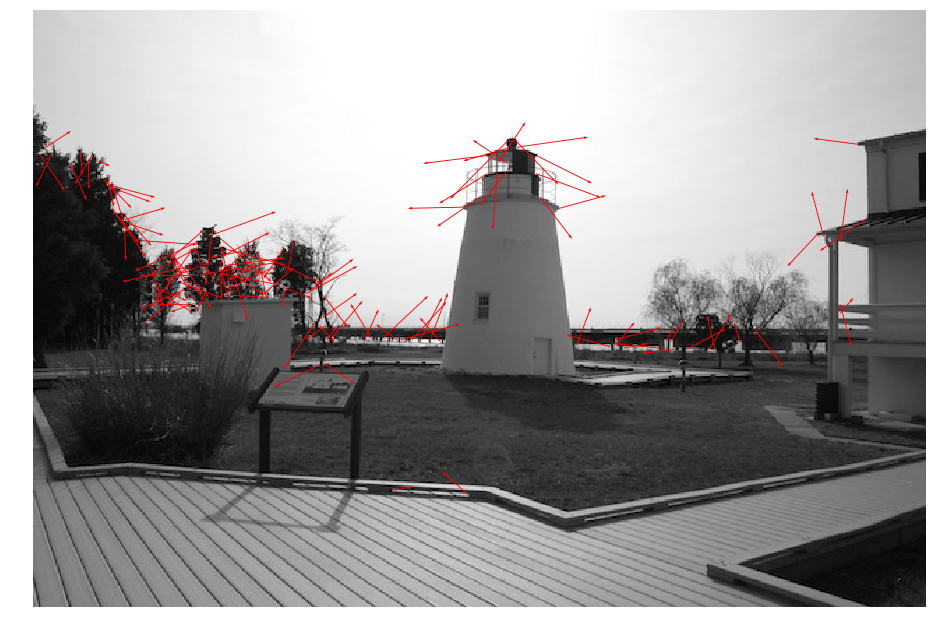

In [3]:
img = cv2.imread("data/sample/images/frame_10.jpg", cv2.IMREAD_GRAYSCALE)
ksize = (5, 5)  # size of the window w(u, v)
sigma = 1.  # standard deviation of a Gaussian filter w(u, v)
kappa = 0.05  # Harris-Stephens corner score parameter
threshold_ratio = 0.1  # "corners" are larger than threshold_ratio * max(Mc)

# compute the directional gradients
Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# Gaussian could be replaced with box filter averaging in the windowed sum-products
M_Ixx = cv2.GaussianBlur(Ix * Ix, ksize, sigma)
M_Iyy = cv2.GaussianBlur(Iy * Iy, ksize, sigma)
M_Ixy = cv2.GaussianBlur(Ix * Iy, ksize, sigma)

# Each location x, y in Mc contains the corner "score" for the corresponding pixel
R = (M_Ixx * M_Iyy - M_Ixy * M_Ixy) - kappa * (M_Ixx + M_Iyy)**2

# Perform local non-maximal suppression & filter according to score
y, x = np.where((R == cv2.dilate(R, np.ones(ksize))) & (R > threshold_ratio * R.max()))
plt.figure(figsize=(16, 12))
plt.imshow(img, cmap="gray");
# plt.scatter(x, y, s=1, c='r');  # plot the keypoints
plt.quiver(x, y, Ix[y, x], Iy[y, x], color='r', width=0.001);  # plot the gradient magnitude & direction
plt.axis("off");

In [10]:
kappa = 0.05  # Harris-Stephens corner score parameter

# compute the directional gradients
Ix = np.array([[0, 1, 0],
              [1, 0, 1],
              [1, 0, 1]])

Iy = np.array([[0, 1, 1],
              [1, 0, 0],
              [0, 1, 1]])

# Gaussian could be replaced with box filter averaging in the windowed sum-products
M_Ixx = np.sum(Ix * Ix)
M_Iyy = np.sum(Iy * Iy)
M_Ixy = np.sum(Ix * Iy)

# Each location x, y in Mc contains the corner "score" for the corresponding pixel
R = (M_Ixx * M_Iyy - M_Ixy * M_Ixy) - kappa * (M_Ixx + M_Iyy)**2

# Perform local non-maximal suppression & filter according to score
R

11.0

---
## Part 2 - Feature Descriptors
---
Feature detection finds _where_ a point of interest is located, but the points alone lose image context in describing the features they represent. In the previous example, we expanded the Harris corners using the gradient magnitude and angle, but better feature descriptions are more robust to changes in perspective and pixel intensity.

OpenCV implements several detectors for more robust feature descriptors like SIFT, SURF, ORB, and HoG, which offer different levels of accuracy & speed. Next we'll cover [Histogram of Oriented Gradients (HoG)](http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) descriptors, which are simpler to demonstrate than the multiscale feature descriptors like [SIFT](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf). (Conceptually, SIFT progressivly extracts locally maximal features from multiscale image pyramids -- the same kind used for pyramid blending.)

HoG feature descriptors are generated by splitting an input window of interest into non-overlapping _cells_ of a fixed size and computing a weighted histogram of the gradient directions of the pixels in each cell into a fixed number of _bins_. Next, the cells are grouped into overlapping _blocks_, and the descriptors for the cells in the block are concatenated and normalized. The final feature descriptor for the window is simply the concatenation of all the block descriptors. By default, HoG feature descriptors describe the entire image. Detecting multiscale features involves applying the same procedure to a sliding window over the image and iterating over multiple scales.

In the example below, the window of interest is the full image. It contains 4x4=16 cells, and the cells are grouped into 2x2 blocks. The blocks are computed by sliding a 2x2 box over the cells (the red block moves to the green block, then the blue block, then the black block, and so on over the rest of the image). The Final feature descriptor is the concatenation of the normalized vector in each block, which is a 4x4x3x3x9=1296 element vector.
![](blocks.png)

In [ ]:
# read the image as grayscale for simplicity; the source paper states, "For colour
# images, we calculate separate gradients for each colour channel, and take the one
# with the largest norm as the pixel’s gradient vector."
img = cv2.imread("data/sample/images/frame_01.jpg", cv2.IMREAD_GRAYSCALE)
cell_size = (8, 8)
nbins = 9

# resize the image to make each dimension a power of 2 so that it is evenly partitioned
# into cells. The source paper used (128x64) window patches for human detection.
img = cv2.resize(img, (256, 256))

# define a few arbitrary cell patches in the image for visualization
patch_count = 0
locations = {(8, 29): 'y', (17, 25): 'r', (24, 12): 'b', (8, 11): 'g'}
plt.figure(figsize=(12, 16))
img_ax = plt.subplot2grid((6, 4), (0, 0), colspan=4, rowspan=4)
plt.imshow(img, cmap="gray");
plt.axis("off");

# compute the directional gradients & convert to magnitude/angle; this deviates from
# the source paper which states, "Simple 1-D [−1, 0, 1] masks at σ=0 [i.e., with no
# smoothing] work best."
Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
mag, ang = cv2.cartToPolar(Ix, Iy)

# discretize the angles to integers mapped to each bin. By default use unsigned gradients,
# i.e., 9 bins at 0, 20, 40, ..., 160; angles that are separated by 180 degrees map to the
# same bin -- e.g., the angles 0 and 180 map to bin 0; 160 and 340 map to bin 8; etc. You
# can also try signed gradients, which maps the 9 bins at 40 degree increments around the
# whole 360 degree circle; this is usually a tunable option. For simplicity, this step
# deviates from the source paper, which interpolates the bins between bin centers; i.e., 
# a pixel at 10 degrees would contribute to both the the bin centered at 0 degrees and the
# bin centered at 20 degrees.
bins = np.int64((2 * nbins * ang / (2 * np.pi)) % nbins)  # unsigned gradients
# bins = np.int64(nbins * ang / (2 * np.pi))  # signed gradients

# calculate the weighted histogram for every cell
hist_shape = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1], nbins)
hist = np.zeros(hist_shape)

# the two outer loops over (j, i) visit each cell in the image
for j in range(hist_shape[0]):
    lo_row = j * cell_size[0]
    hi_row = (j + 1) * cell_size[0]
    for i in range(hist_shape[1]):
        lo_col = i * cell_size[1]
        hi_col = (i + 1) * cell_size[1]
        cell = bins[lo_row:hi_row, lo_col:hi_col]
        cell_mag = mag[lo_row:hi_row, lo_col:hi_col]
        
        # compute the histogram of the current cell by summing the magnitude
        # of the gradients for each bin
        for k in range(nbins):
            hist[j, i, k] = np.sum(cell_mag[cell == k])
            
        # draw individual cells & the corresponding histograms -- this code is not part of the HoG algorithm
        if (j, i) in locations:
            color = locations[(j, i)]
            img_ax.add_patch(patches.Rectangle((lo_col, lo_row), *cell_size, fill=False, color=color, lw=3.))

            patch_ax = plt.subplot2grid((6, 4), (4, 0 + patch_count))
            plt.imshow(img[lo_row:hi_row, lo_col:hi_col], cmap="gray");
            plt.setp(patch_ax.spines.values(), color=color, lw=3.)
            plt.tick_params(axis='both', which='both', labelbottom='off', labelleft='off', bottom='off', left='off')
            
            hist_ax = plt.subplot2grid((6, 4), (5, 0 + patch_count))
            plt.bar(range(nbins), hist[j, i])
            plt.tick_params(axis='both', which='both', labelleft='off', bottom='off', left='off')
            plt.xlabel("patch {} histogram".format(patch_count))
            patch_count += 1

In [ ]:
# normalize within each block and combine the blocks to make a single feature descriptor for the window
block_size = (3, 3)  # blocks are rectangular groups of cells; e.g., 3x3 blocks is a group of 9 cells
row_blocks = hist.shape[0] - block_size[0] + 1
col_blocks = hist.shape[1] - block_size[1] + 1
block_vector_size = block_size[0] * block_size[1] * nbins
blocks = np.zeros((row_blocks, col_blocks, block_vector_size))
eps = 1e-3
for j in range(row_blocks):
    for i in range(col_blocks):
        block = hist[j:j+block_size[0], i:i+block_size[1]]

        # normalization using the L2 norm
        blocks[j, i] = block.flatten() / np.sqrt(np.sum(block**2) + eps**2)

        # alternative normalization using the L1 norm 
        #  blocks[j, i] = block.flatten() / (np.sum(block) + eps)

feature_vector = blocks.flatten()
print("The feature vector contains {} values".format(feature_vector.shape[0]))
plt.figure()
plt.bar(range(128), feature_vector[:128])  # plot a subset of the feature descriptor
plt.title("Portion of normalized HoG feature vector");

In [9]:
img_shape = (128, 64)
nbins = 9
cell_size = (8, 8)
block_size = (3, 3)  # blocks are rectangular groups of cells; e.g., 3x3 blocks is a group of 9 cells

hist_shape = (img_shape[0] // cell_size[0], img_shape[1] // cell_size[1], nbins)

row_blocks = hist_shape[0] - block_size[0] + 1
col_blocks = hist_shape[1] - block_size[1] + 1
block_vector_size = block_size[0] * block_size[1] * nbins
block_vector_size, row_blocks * col_blocks * block_vector_size

(81, 6804)

---
## Part 3 - Applications: Structure from Motion
---
Once you can robustly detect and identify features of interest, you can use them to register & align multiple images of the same scene. (For example in panorama stitching.) The general solution to this problem is called [global bundle adjustment](https://en.wikipedia.org/wiki/Bundle_adjustment). Bundle adjustment quickly becomes intractable for large image sets because it involves solving a large sparse system of nonlinear equations. Practical solutions simplify the problem by exploiting structure from the application (e.g., sequential images in panorama construction are likely to include the same objects), or limiting the number of images that are pooled together during registration then initializing the global solution with the partial solution of each pooled group. 

[OpenSfM](https://github.com/mapillary/OpenSfM) is an open source tool that implements several modern techniques to extract 3d point information from large collections of images. By default, it uses HAHoG feature descriptors (which are not very accurate, but are _very_ fast to compute compared to descriptors like SIFT).

Run the next cell to see an example of the output it produces (the inputs are in the /data folder) or [click here](../files/features_keypoints/viewer/reconstruction.html#file=../data/sample/reconstruction.meshed.json) to open it in another tab or window. You can scroll to zoom, and double click on the camera markers to enter a first-person projection view at that point.

In [ ]:
%%html
<iframe src="../files/3-features_keypoints/viewer/reconstruction.html#file=../data/sample/reconstruction.meshed.json" width=1024 height=600></iframe>

You can process your own pictures with OpenSfM using the Docker image provided by OpenSfM or with the CS6475 course VM. Your pictures need to be in a folder like the "data/sample" folder (the "data/your_images" folder is provided as a template). OpenSfM is installed on the CS6475 VM, so you can connect to the VM with `vagrant ssh` then `cd` into the lab_exercises folder and process the sample set by running:

```
lab_exercises$ opensfm 3-feature_keypoints/data/sample
```

The sample set should finish processing in less than one minute. You can process your own images by changing the target directory to `3-feature_keypoints/data/your_images` 

## Part 4 - Challenges

### 4.1 Modify the Harris detector & compare the results with the original
 - Replace the Sobel derivatives in the Harris detector with other gradient operators (np.gradient, cv2.scharr, etc.)
 - Replace the Gaussian windowed sum-product with a box filter

### 4.2 Extend the HoG descriptor & compare it against the OpenCV or scikit-image HoG detectors
 - Vectorize the HoG descriptor function
 - Extend the HoG detector to work on multiscale features

### 4.3 Use your Harris corners to align images for panoramas
 - Implement [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus), then replace the SIFT/SURF/ORB feature detector in the panorama assignment with your Harris corner + RANSAC detector

### 4. Take your own image sequence and explore Structure from Motion
 - Take your own picture sequence and process it with OpenSfM
 - Explore the OpenSfM documentation for examples of dense point cloud reconstruction
 - Build your own photosynth or hyperlapse; to get the best results, you should take _many_ photos very close together (about 1 step between each), and try to avoid sharp turns